In [1]:
import pandas as pd
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, optimizers, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix


In [2]:
# Here we create a dict which consists label for each image path and its particular data.
def load_file(file_path, label):

    # declare the folder name
    folder_name = file_path.split("/")[-1]
    # declare output list
    out_list = []
    # load every file that .png format
    for image_path in glob.glob(file_path + "/*.*"):
        # read image file
        image = imageio.imread(image_path)
        # declare temporary dict dtype
        temp = {}
        # set the file name
        temp["name"] = image_path.split("/")[-1]
        # set the file label, 0 for non defect. 1 for defect
        temp["label"] = label

        # There are somes images are tensor dtype
        # Thus I fix by selecting only a tensor index zero
        try:   
            temp["data"] = image[:,:,0].astype("int") 
        except:
            # normal case
            temp["data"] = image.astype("int")
        # append temp into output list
        out_list.append(temp)
    # print process status by checking size of output list
    if len(out_list) == 0:
        print("loading files from folder: {} is failed".format(folder_name))
    else:
        print("loading file from folder: {} is successful".format(folder_name))
    # convert list into numpy array dtype
    return np.array(out_list)

In [3]:
defect_images_path      =  r"path_of_defected_images"
non_defect_images_path1 =  r"path_of_non_defect_resized_images"

In [4]:
defect_images = load_file(file_path=defect_images_path, label=1)
non_defect_images = load_file(file_path=non_defect_images_path1, label=0)

loading file from folder: A:\TechieYan projects\AI\Fabric_Fault_detection\Fabric 2\augmented_images is successful
loading file from folder: A:\TechieYan projects\AI\Fabric_Fault_detection\Fabric 2\non_defect_resized_images is successful


In [5]:
defect_images.shape

(2251,)

In [7]:
non_defect_images.shape

(2000,)

In [6]:
defect_images

array([{'name': 'A:\\TechieYan projects\\AI\\Fabric_Fault_detection\\Fabric 2\\augmented_images\\aug_0_10.png', 'label': 1, 'data': Array([[ 63,  49,  49, ...,  75,  79,  75],
              [ 83,  72,  56, ...,  78,  77,  71],
              [ 96,  88,  79, ...,  79,  73,  67],
              ...,
              [100,  97,  95, ...,  33,  34,  39],
              [ 98,  95,  94, ...,  39,  29,  28],
              [ 96,  94,  94, ...,  69,  56,  39]])}                                                                                                                           ,
       {'name': 'A:\\TechieYan projects\\AI\\Fabric_Fault_detection\\Fabric 2\\augmented_images\\aug_0_1002.png', 'label': 1, 'data': Array([[96, 95, 78, ..., 29, 28, 27],
              [94, 96, 86, ..., 20, 16, 16],
              [88, 96, 95, ..., 20, 21, 24],
              ...,
              [72, 71, 72, ..., 34, 29, 21],
              [77, 80, 79, ..., 35, 32, 25],
              [78, 77, 75, ..., 37, 34, 29]])}       

## **Prepare and clean the data to avoid error during model fitting.**

In [11]:
np.random.shuffle(non_defect_images)
np.random.shuffle(defect_images)

# the class size is the min length compared with defect-free and defect images, we do this in orde to balance the dataset.
if defect_images.shape[0] <= non_defect_images.shape[0]:
  class_size = defect_images.shape[0]
else:
  class_size = non_defect_images.shape[0]
print("Class Size:", class_size)


Class Size: 2000


In [12]:
# we shuffle the order of defect-free and defect images
np.random.shuffle(non_defect_images)
np.random.shuffle(defect_images)

# the class size is the min length compared with defect-free and defect images, we do this in orde to balance the dataset.
if defect_images.shape[0] <= non_defect_images.shape[0]:
  class_size = defect_images.shape[0] 
else:
  non_defect_images.shape[0]
print("Class Size:", class_size)

# Concatenate both the datasets with size as class_size.
dataset = np.concatenate((defect_images[:class_size], non_defect_images[:class_size]))

# create an empty matrix X of 256x4096 and has dataset length row, which holds all the data i.e images from dataset.
# Independent Features -> X
X = np.empty([dataset.shape[0], 255, 255]).astype(int)

# create vector y which has dataset length, which holds all the labels for our data, this is jsut similar to partitioning the data before splitting, 
# Target_variable -> y
y = np.empty(dataset.shape[0]).astype(int)

# assign the X,y one-by-one
for i in range(dataset.shape[0]):
    X[i] = dataset[i]["data"]
    y[i] = dataset[i]["label"]

# since Keras acquire the Image input in a tensor type -> we reshape X
X = X.reshape(X.shape[0], 255, 255, 1)
print(X.shape)

# display size of the label 0 and label 1 
np.unique(y, return_counts=True)


Class Size: 2000
(4000, 255, 255, 1)


(array([0, 1]), array([2000, 2000], dtype=int64))

## **Model Building**

In [13]:
def create_model(image_shape=(256, 4096, 1), print_summary=True):
    # initial model
    model = models.Sequential()

    # CONV layer: filter 16, stride 7x7
    model.add(layers.Conv2D(16, (7, 7),input_shape=image_shape))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer 
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))


    # CONV layer: filter 32, stride 5x5
    model.add(layers.Conv2D(32, (5, 5), padding="same"))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer 
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))
    
    # CONV layer: filter 64, stride 5x5
    model.add(layers.Conv2D(64, (5, 5), padding="same"))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer 
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))



    # flatten layer -> To convert from matrix to vector ie from multidimensional array to 1D array with single column.
    model.add(layers.Flatten())
    

    # Here we are creating an actual neural network which takes input as the flatten layer.
    # fully connected layer -> nn layer with 64 nodes
    model.add(layers.Dense(64))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer 
    model.add(layers.Activation('relu'))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))


    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    
    # set model compiler
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # show the CNN model detail
    if print_summary:
        model.summary()
    return model

def train_model(model, xtrain, ytrain, xval, yval, n_epoch, batch_size):
    # train CNN model
    # batch size to reduce memory usage
    # set early stopping to avoid overfitting
    
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=2)
    filepath = "/content/drive/MyDrive/Fabric_Fault_detection/Fabric 2/model/weights-best-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, earlystopping]

    history = model.fit(xtrain, ytrain, epochs=n_epoch, batch_size=batch_size, validation_data=(xval, yval), callbacks=[callbacks_list])
    return history

create_model(image_shape=(255, 255, 1), print_summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 249, 249, 16)      800       
                                                                 
 batch_normalization (BatchN  (None, 249, 249, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 249, 249, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 124, 124, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      1

## Train and Export CNN Model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)
print("y_train: number of samples each class: {}".format(np.unique(y_train, return_counts=True)))
print("y_test: number of samples each class: {}".format(np.unique(y_test, return_counts=True)))

y_train: number of samples each class: (array([0, 1]), array([1600, 1600], dtype=int64))
y_test: number of samples each class: (array([0, 1]), array([400, 400], dtype=int64))


In [15]:
cnn_model = None
cnn_model = create_model(image_shape=(255, 255, 1))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 249, 249, 16)      800       
                                                                 
 batch_normalization_4 (Batc  (None, 249, 249, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 249, 249, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 124, 124, 16)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 124, 124, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 32)     

In [16]:
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10)
filepath = "A:\TechieYan projects\AI\Fabric_Fault_detection\Fabric 2\model\weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, earlystopping]

In [12]:
# No need to run this, if you are loading the model, if not you cna run this to train your model again and save another weights file.
# cnn_model.fit(X_train, y_train, batch_size=10, epochs=10, validation_split=0.1, callbacks=callbacks_list)

Epoch 1/10
288/288 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.6764
Epoch 00001: val_accuracy improved from -inf to 0.65938, saving model to A:\TechieYan projects\AI\Fabric_Fault_detection\Fabric 2\model\weights_best.hdf5
288/288 [==============================] - 304s 1s/step - loss: 0.5936 - accuracy: 0.6764 - val_loss: 0.9034 - val_accuracy: 0.6594
Epoch 2/10
288/288 [==============================] - ETA: 0s - loss: 0.4465 - accuracy: 0.7955
Epoch 00002: val_accuracy improved from 0.65938 to 0.70938, saving model to A:\TechieYan projects\AI\Fabric_Fault_detection\Fabric 2\model\weights_best.hdf5
288/288 [==============================] - 260s 901ms/step - loss: 0.4465 - accuracy: 0.7955 - val_loss: 1.1755 - val_accuracy: 0.7094
Epoch 3/10
288/288 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8375
Epoch 00003: val_accuracy did not improve from 0.70938
288/288 [==============================] - 257s 892ms/step - loss: 0.3718 - acc

In [32]:
my_model = tf.keras.models.load_model("path-of_saved_model")

In [15]:
score, acc = my_model.evaluate(X_test, y_test, verbose=0)
score, acc

(0.13624490797519684, 0.949999988079071)

In [16]:
y_pred = cnn_model.predict(X_test)

In [20]:
y_pred

array([[0.9378993 ],
       [0.02002826],
       [0.9989196 ],
       [0.67123127],
       [0.4215867 ],
       [0.907607  ],
       [0.0552637 ],
       [0.9459765 ],
       [0.9992254 ],
       [0.9969977 ],
       [0.00795773],
       [0.09753716],
       [0.9976649 ],
       [0.9638246 ],
       [0.99827945],
       [0.1274018 ],
       [0.9992366 ],
       [0.51289654],
       [0.9973637 ],
       [0.01850489],
       [0.04367355],
       [0.04167131],
       [0.7128489 ],
       [0.99977744],
       [0.00329408],
       [0.37138253],
       [0.9211412 ],
       [0.98227155],
       [0.00913477],
       [0.21792486],
       [0.9991604 ],
       [0.10970008],
       [0.99946034],
       [0.6862777 ],
       [0.01467851],
       [0.7078783 ],
       [0.99528897],
       [0.7949919 ],
       [0.01371315],
       [0.84297264],
       [0.63125163],
       [0.8683301 ],
       [0.9976413 ],
       [0.05072001],
       [0.9990978 ],
       [0.9994143 ],
       [0.92707044],
       [0.037

In [25]:
len(y_pred)

800

In [42]:
ab = y_pred.reshape(-1, 1)

In [48]:
count = len(y_pred)
count

800

In [49]:
for i in range(count):
    if y_pred[i] > 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

In [50]:
y_pred

array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],

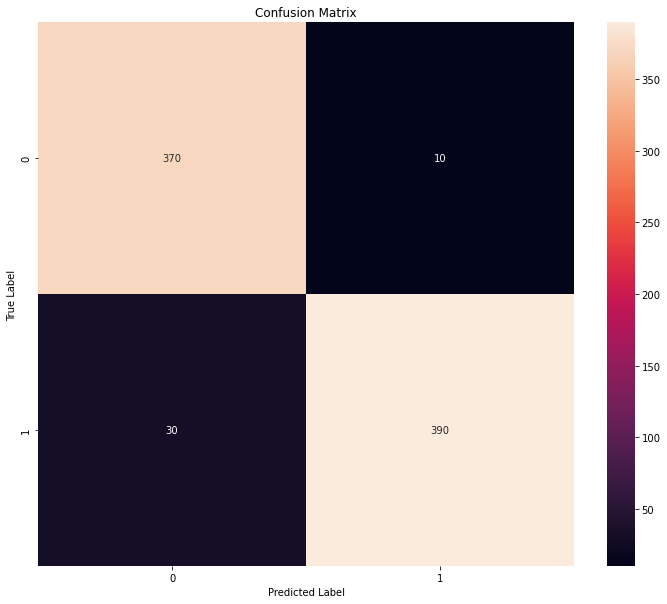

In [51]:
plt.figure(figsize = (12,10))
cf_matrix = confusion_matrix(y_pred,y_test)
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### Testing on Single Image

In [ ]:
y_test[73]

In [ ]:
xi = np.array(X_test[73]).reshape(-1, 255, 255, 1)
print(xi.shape)

In [ ]:
y_pred = cnn_model.predict(xi)
y_pred
if y_pred > 0.5:
    y_pred = 1
    print("The Fabric is Defect.")
else:
    y_pred = 0
    print("The Fabric is good.")